In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import networkx as nx
from tqdm import tqdm

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [2]:
years = 3
date_to = "30.05.2023"

imoex_shares_path = "../data/tickers_info/imoex_shares.csv"
imoex_index_shares_path = "../data/tickers_info/imoex_index_shares.csv"
imoex_index_tickers_path = "../data/tickers_info/imoex_index_tickers.csv"
figi_load_path = "../data/historical/figi_to_load.txt"
daily_data_folder = f"../data/historical/daily_data_for_{years}_years_till_{datetime.strptime(date_to, '%d.%m.%Y').strftime('%Y-%m-%d')}/"

def daily_data_fname(ticker, uid):
    return f"{ticker}_{uid}.csv"

In [3]:
shares_info = pd.read_csv(imoex_index_shares_path)
shares_info.head(5)

,figi,ticker,name,uid
0,BBG000RMWQD4,ENPG,En+ Group,e2bd2eba-75de-4127-b39c-2f2dbe3866c3
1,BBG004PYF2N3,POLY,Polymetal,127361c2-32ec-448c-b3ec-602166f537ea
2,BBG004RVFCY3,MGNT,Магнит,ca845f68-6c43-44bc-b584-330d2a1e5eb7
3,BBG00ZHCX1X2,FIXP,Fix Price Group,ba64a3c7-dd1d-4f19-8758-94aac17d971b
4,BBG00178PGX3,VKCO,VK,3c0748ce-9b49-43e9-b788-048a6cb65174


In [45]:
common_df = None
for idx, info in shares_info.iterrows():
    cur_df = pd.read_csv(daily_data_folder + daily_data_fname(info["ticker"], info["uid"]), index_col=0)
    cur_df.index = pd.to_datetime(cur_df.index)
    # From book
    # cur_df = pd.DataFrame(np.log(cur_df["close"] / cur_df["open"]), columns=[info["ticker"]])
    # Diff
    cur_df = pd.DataFrame((cur_df["close"] - cur_df["open"]) / cur_df["open"], columns=[info["ticker"]])
    if common_df is None:
        common_df = cur_df
    else:
        common_df = common_df.join(cur_df)
common_df = common_df.fillna(0).sort_index()
common_df

,ENPG,POLY,MGNT,FIXP,VKCO,PHOR,AGRO,TATNP,MAGN,VTBR,...,AFKS,PLZL,OZON,LKOH,GLTR,SNGS,CBOM,PIKK,ROSN,CHMF
2020-05-29,-0.0024,-0.0134,-0.0181,0.0000,0.0000,-0.0252,0.0000,-0.0373,-0.0261,0.0114,...,0.0200,0.0250,0.0000,-0.0256,0.0000,-0.0179,0.0140,0.0076,0.0045,-0.0017
2020-06-01,0.0114,-0.0215,0.0219,0.0000,0.0000,0.0057,0.0006,0.0037,0.0054,0.0060,...,0.0230,-0.0215,0.0000,-0.0059,0.0000,-0.0047,0.0031,-0.0205,-0.0034,-0.0017
2020-06-02,0.0072,-0.0027,0.0127,0.0000,0.0000,0.0011,-0.0018,-0.0019,0.0024,0.0118,...,0.0240,-0.0209,0.0000,0.0080,0.0000,0.0025,0.0085,0.0032,0.0169,0.0070
2020-06-03,-0.0056,-0.0574,-0.0116,0.0000,0.0000,0.0071,-0.0009,0.0281,0.0188,0.0193,...,-0.0145,-0.0365,0.0000,0.0183,0.0000,-0.0121,0.0044,0.0119,0.0173,0.0042
2020-06-04,-0.0443,-0.0036,-0.0088,0.0000,0.0000,-0.0074,-0.0223,-0.0128,-0.0018,-0.0190,...,0.0601,0.0184,0.0000,-0.0182,0.0000,0.0035,-0.0074,0.0134,-0.0164,-0.0099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-25,-0.0108,-0.0370,-0.0351,-0.0133,-0.0048,-0.0095,0.0111,-0.0053,0.0085,-0.0161,...,-0.0039,-0.0095,-0.0019,0.0011,-0.0003,-0.0064,-0.0215,-0.0024,-0.0176,0.0127
2023-05-26,-0.0054,0.0355,0.0248,0.0023,0.0329,0.0106,0.0331,0.0051,-0.0060,0.0058,...,0.0034,0.0130,-0.0056,0.0171,-0.0017,0.0075,-0.0086,0.0150,0.0094,-0.0042
2023-05-27,-0.0027,-0.0045,0.0090,0.0000,0.0108,0.0125,-0.0020,0.0091,-0.0018,-0.0066,...,-0.0042,0.0093,0.0070,0.0083,0.0000,-0.0063,0.0009,0.0004,0.0030,-0.0042
2023-05-28,0.0110,0.0003,-0.0140,0.0000,0.0011,-0.0117,-0.0071,-0.0071,-0.0072,-0.0073,...,-0.0037,-0.0018,-0.0066,-0.0063,0.0000,0.0008,-0.0005,0.0006,-0.0005,0.0020


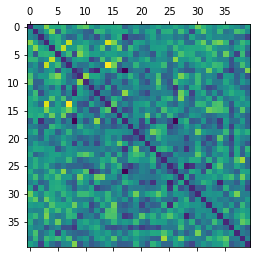

In [46]:
common_edges = common_df.tail(30).corr(method="kendall").values
np.fill_diagonal(common_edges, 0)
plt.matshow(common_edges)

In [47]:
date_min = common_df.index.min()
date_max = common_df.index.max()
print(f"We have data from {date_min.date()} to {date_max.date()} inclusive")

We have data from 2020-05-29 to 2023-05-29 inclusive


In [48]:
# Choosing periods for market graphs. Let's take it monthly, yearly and overall. First inclusive, second exclusive

periods = []

# Overall period
periods.append((date_min, date_max + timedelta(days=1)))

# Yearly periods
period = timedelta(days=365)
d_start_tmp = date_min
while d_start_tmp + period < date_max:
    periods.append((d_start_tmp, d_start_tmp + period))
    d_start_tmp += period
if d_start_tmp + period - date_max < timedelta(days=10):
    periods.append((d_start_tmp, date_max + timedelta(days=1)))

# Monthly periods
period = timedelta(days=30)
d_start_tmp = date_min
while d_start_tmp + period < date_max:
    periods.append((d_start_tmp, d_start_tmp + period))
    d_start_tmp += period
if d_start_tmp + period - date_max < timedelta(days=10):
    periods.append((d_start_tmp, date_max + timedelta(days=1)))

periods[-5:]

[(Timestamp('2022-12-15 00:00:00'), Timestamp('2023-01-14 00:00:00')),
 (Timestamp('2023-01-14 00:00:00'), Timestamp('2023-02-13 00:00:00')),
 (Timestamp('2023-02-13 00:00:00'), Timestamp('2023-03-15 00:00:00')),
 (Timestamp('2023-03-15 00:00:00'), Timestamp('2023-04-14 00:00:00')),
 (Timestamp('2023-04-14 00:00:00'), Timestamp('2023-05-14 00:00:00'))]

  0%|          | 0/40 [00:00<?, ?it/s]

[]


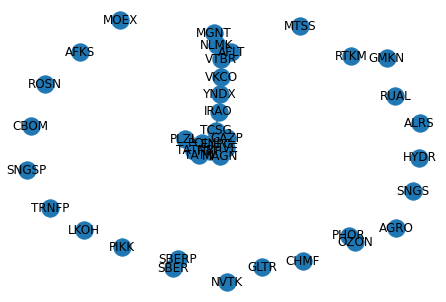

In [96]:
threshold = 0.5

cliques = []
for period in tqdm(periods[::-1]):
    # Calculating Kendall correlation
    sub_df = common_df.loc[(period[0] <= common_df.index) & (common_df.index < period[1])]
    vertices = sub_df.columns
    edges = np.abs(sub_df.corr(method="kendall"))

    # Building a threshold market graph
    np.fill_diagonal(edges.values, 0)
    G = nx.Graph()
    G.add_nodes_from(vertices)
    for i in range(edges.shape[0]):
        for j in range(i+1, edges.shape[0]):
            if edges.values[i, j] > threshold:
                G.add_edge(vertices[i], vertices[j])
    
    # Finding a maximum clique
    cliques.append(nx.approximation.max_clique(G))
    break
print(cliques[:-1])
nx.draw(G, with_labels=True)

In [44]:
cliques[4:4+12]

[{'IRAO', 'MTSS', 'PLZL', 'RUAL', 'SBER', 'SBERP', 'TATN'},
 {'CHMF',
  'GAZP',
  'IRAO',
  'LKOH',
  'ROSN',
  'SBER',
  'SBERP',
  'TATN',
  'TATNP',
  'VTBR'},
 {'AFLT',
  'CHMF',
  'GAZP',
  'GMKN',
  'MOEX',
  'SBER',
  'SBERP',
  'SNGS',
  'TATN',
  'TRNFP'},
 {'AFLT',
  'CHMF',
  'GAZP',
  'HYDR',
  'IRAO',
  'LKOH',
  'NLMK',
  'SBER',
  'SBERP',
  'SNGS',
  'TATN',
  'TRNFP'},
 {'AFLT', 'LKOH', 'MAGN', 'ROSN', 'SBER', 'SBERP', 'TATNP', 'VTBR'},
 {'ALRS',
  'CBOM',
  'GAZP',
  'GMKN',
  'LKOH',
  'NVTK',
  'ROSN',
  'SNGS',
  'TATN',
  'TATNP',
  'VTBR'},
 {'CHMF', 'ENPG', 'LKOH', 'MAGN', 'NVTK', 'ROSN', 'SNGS', 'TATN', 'TATNP'},
 {'AFLT',
  'ENPG',
  'GAZP',
  'GMKN',
  'IRAO',
  'MGNT',
  'MTSS',
  'RUAL',
  'SBER',
  'SBERP',
  'SNGS',
  'TATN',
  'YNDX'},
 {'AFKS',
  'AFLT',
  'GAZP',
  'IRAO',
  'NLMK',
  'NVTK',
  'SBER',
  'SBERP',
  'SNGS',
  'SNGSP',
  'TATN',
  'TATNP',
  'VTBR'},
 {'GAZP', 'LKOH', 'NVTK', 'SBERP', 'SNGS', 'TATN', 'VTBR'},
 {'CHMF',
  'ENPG',
  'GMKN'

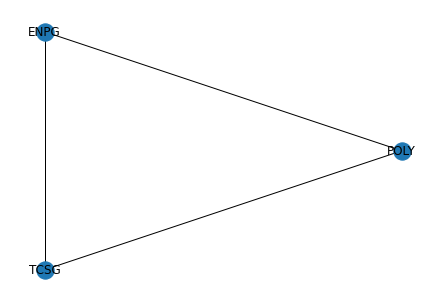

In [97]:
nx.draw_circular(G.subgraph(nx.approximation.max_clique(G)), with_labels=True)

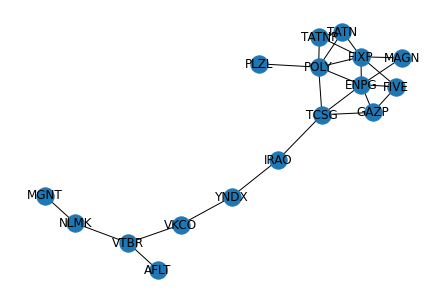

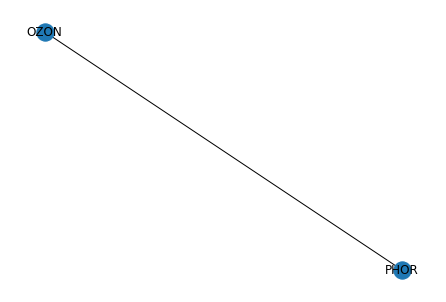

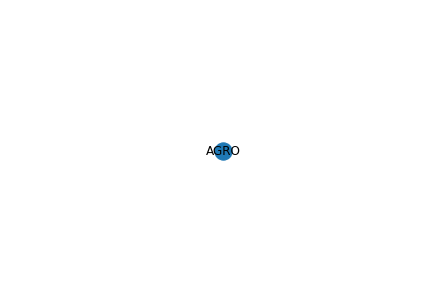

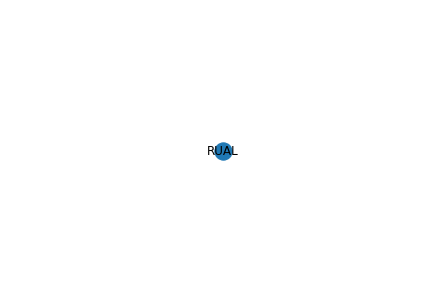

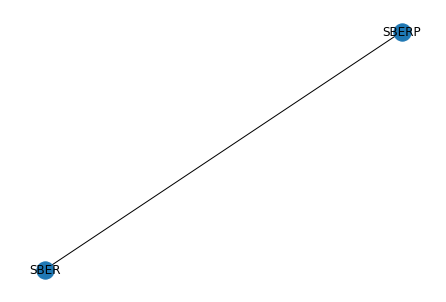

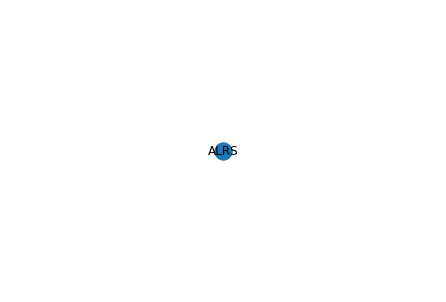

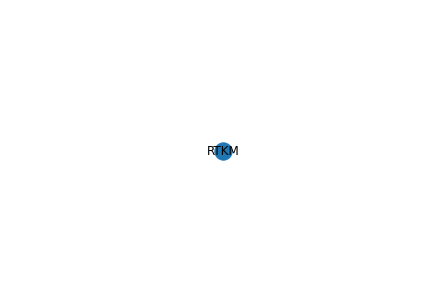

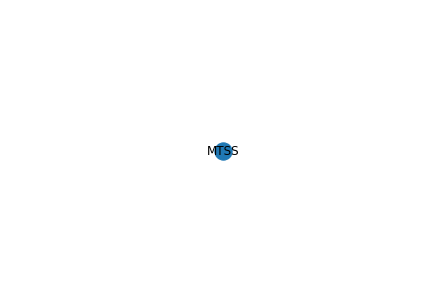

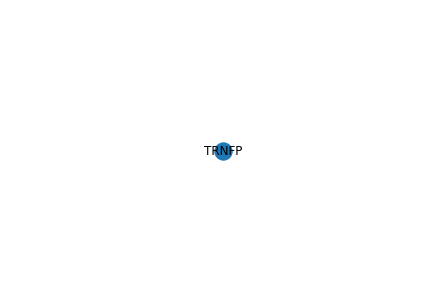

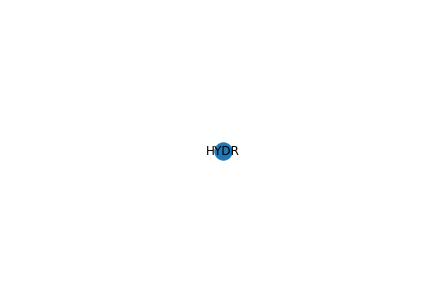

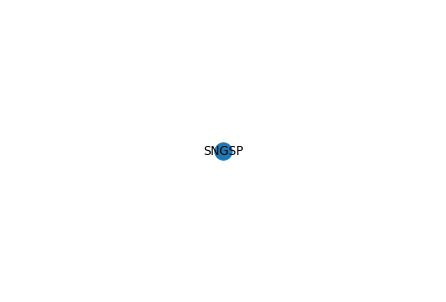

In [102]:
for i, component in enumerate(nx.connected_components(G)):
    nx.draw_spring(G.subgraph(component), with_labels=True)
    plt.pause(0.05)
    if i == 10:
        break